In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Input
from keras.models import Model
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

results = []

In [2]:
# Load dataset
def load_and_preprocess_data(filepath):
    dataset = pd.read_excel(filepath)
    dataset = dataset.dropna()
    dataset = dataset.select_dtypes(exclude=['object'])
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(dataset)
    return data_scaled

data02_scaled = load_and_preprocess_data(r"Dataset ML.xls")


K-means 2 clusters - Silhouette Score: 0.06561172867930795
K-means 3 clusters - Silhouette Score: 0.04567925469182742
K-means 4 clusters - Silhouette Score: 0.039671922821198545
K-means 5 clusters - Silhouette Score: 0.03625362527440281
K-means 6 clusters - Silhouette Score: 0.03665684557560245
K-means 7 clusters - Silhouette Score: 0.03479131293054492
K-means 8 clusters - Silhouette Score: 0.02724474504561326
K-means 9 clusters - Silhouette Score: 0.03572712688152114
K-means 10 clusters - Silhouette Score: 0.0440986171695077
Max Silhouette score: 0.06561172867930795 (Cluster: 2)


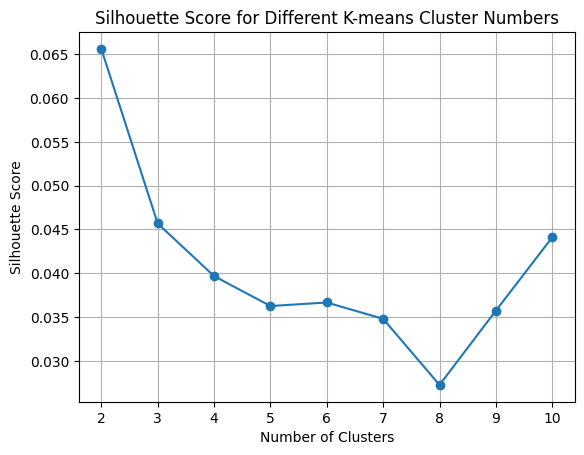

In [3]:
# Function to apply K-means clustering
def apply_kmeans(data, n_clusters=3, random_state=47):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    silhouette = silhouette_score(data, clusters)
    return clusters, silhouette

# Function to compare K-means results with different cluster sizes
def compare_kmeans(data, cluster_range, random_state=47):
    results = []
    for n_clusters in cluster_range:
        clusters, silhouette = apply_kmeans(data, n_clusters, random_state)
        results.append((n_clusters, clusters, silhouette))
    return results

# Example usage with dataset data02_scaled and cluster range [2, 10]
cluster_range = range(2, 11)
kmeans_results = compare_kmeans(data02_scaled, cluster_range)

# Print silhouette scores for each number of clusters
for n_clusters, _, silhouette in kmeans_results:
    print(f'K-means {n_clusters} clusters - Silhouette Score: {silhouette}')

# Find the maximum silhouette score and corresponding number of clusters
silhouette_scores = [silhouette for _, _, silhouette in kmeans_results]
max_silhouette = max(silhouette_scores)
best_n_clusters = cluster_range[silhouette_scores.index(max_silhouette)]
print(f'Max Silhouette score: {max_silhouette} (Cluster: {best_n_clusters})')

# Visualize Silhouette scores
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Different K-means Cluster Numbers')
plt.grid(True)
plt.savefig('kmeans_silhouette_scores.png')  # Save the plot as PNG
plt.show()

In [8]:
# Function to build autoencoder
def build_autoencoder(input_dim, encoding_dim):
    input_layer = Input(shape=(input_dim,))
    encoder = Dense(encoding_dim, activation='relu')(input_layer)
    decoder = Dense(input_dim, activation='sigmoid')(encoder)
    autoencoder = Model(input_layer, decoder)
    return autoencoder, Model(inputs=autoencoder.input, outputs=encoder)

# Autoencoder and encoder model for dataset 02
input_dim_02 = data02_scaled.shape[1]
encoding_dim = 3  # Adjust based on the complexity of your dataset

autoencoder_02, encoder_model_02 = build_autoencoder(input_dim_02, encoding_dim)
autoencoder_02.compile(optimizer='adam', loss='mse')

# Callback function to print silhouette score every 100 epochs
class PrintSilhouetteCallback(tf.keras.callbacks.Callback):
    def __init__(self, data, interval=100):
        super(PrintSilhouetteCallback, self).__init__()
        self.data = data
        self.interval = interval

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.interval == 0:
            encoded_data = self.model.predict(self.data)
            clusters = KMeans(n_clusters=3, random_state=42).fit_predict(encoded_data)
            silhouette = silhouette_score(self.data, clusters)
            print(f'Epoch {epoch}, Silhouette Score: {silhouette}')

# Training the autoencoder
history_02 = autoencoder_02.fit(
    data02_scaled, 
    data02_scaled, 
    epochs=900, 
    batch_size=32, 
    shuffle=True, 
    validation_split=0.2, 
    verbose=0,
    callbacks=[PrintSilhouetteCallback(data02_scaled)]
)

# Extracting encoded data
encoded_data02 = encoder_model_02.predict(data02_scaled)

# Applying K-means clustering on encoded data
def apply_kmeans(data, n_clusters=3, random_state=47):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(data)
    silhouette = silhouette_score(data, clusters)
    return clusters, silhouette

# Trying different cluster numbers with K-means on encoded data
results_deep = []
for n_clusters in range(2, 11):
    clusters_deep_02, silhouette_deep_02 = apply_kmeans(encoded_data02, n_clusters=n_clusters)
    print(f'Dataset 02 - Deep Neural Clustering with {n_clusters} clusters, Silhouette Score: {silhouette_deep_02}')
    results_deep.append(f'Dataset 02 - Deep Neural Clustering with {n_clusters} clusters, Silhouette Score: {silhouette_deep_02}')

# Printing the results
best_result_deep = max(results_deep, key=lambda x: float(x.split(":")[-1].strip()))
print(f'Best Deep Neural Clustering Result: {best_result_deep}')


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 0, Silhouette Score: 0.011130198070996628
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Epoch 100, Silhouette Score: 0.021839180372150813
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 200, Silhouette Score: 0.03559578167721571
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Epoch 300, Silhouette Score: 0.032713072143960104
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Epoch 400, Silhouette Score: 0.03279294096151762
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step
Epoch 500, Silhouette Score: 0.03298989869984701
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 600, Silhouette Score: 0.028338007815397293
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Epoch 700, Silhouette Score: 0.03911812188548506
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
Epoch 800, Silhouette Score: 0.03911812188548506
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Dataset 02 - Deep Neural Clustering with 2 clusters, Silhouette Score: 0.4123506546020508
Dataset 02 - Deep Neural Clustering with 3 clusters, Silhouette Score: 0.49337878823280

In [10]:
# Function to apply DBSCAN
def apply_dbscan(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan.fit_predict(data)
    if len(np.unique(clusters)) > 1 and len(np.unique(clusters)) != 2:
        silhouette = silhouette_score(data[clusters != -1], clusters[clusters != -1])
        return clusters, silhouette
    else:
        return clusters, None

# Function to compare DBSCAN results with different epsilon and min_samples values
def compare_dbscan(data, eps_values, min_samples_values):
    results = []
    for eps in eps_values:
        for min_samples in min_samples_values:
            clusters, silhouette = apply_dbscan(data, eps, min_samples)
            if silhouette is not None:
                results.append((eps, min_samples, silhouette))
            else:
                results.append((eps, min_samples, 'Noise'))
    return results


# Compare DBSCAN results with different epsilon and min_samples values
eps_values = [0.3, 0.5, 0.7, 0.9]  # Epsilon values
min_samples_values = [3, 5, 7, 9]  # Minimum sample sizes
dbscan_results = compare_dbscan(data02_scaled, eps_values, min_samples_values)

# Print and visualize DBSCAN results
best_silhouette = -1
best_params = None
valid_results = []

for eps, min_samples, silhouette in dbscan_results:
    if silhouette != 'Noise':
        valid_results.append((eps, min_samples, silhouette))
        print(f'DBSCAN with eps={eps}, min_samples={min_samples} - Silhouette Score: {silhouette}')
        if silhouette > best_silhouette:
            best_silhouette = silhouette
            best_params = (eps, min_samples)
    else:
        print(f'DBSCAN with eps={eps}, min_samples={min_samples} - All points are marked as noise.')

if best_params:
    print(f'Highest Silhouette score: {best_silhouette} (eps={best_params[0]}, min_samples={best_params[1]})')

# Visualize Silhouette scores
if valid_results:
    eps_min_samples = [(eps, min_samples) for eps, min_samples, _ in valid_results]
    silhouette_scores = [silhouette for _, _, silhouette in valid_results]

    # Convert epsilon and min_samples pairs to strings for x-axis
    eps_min_samples_str = [f'eps={eps}, min_samples={min_samples}' for eps, min_samples in eps_min_samples]

    plt.figure(figsize=(10, 6))
    plt.bar(eps_min_samples_str, silhouette_scores)
    plt.xlabel('Epsilon and Min Samples Values')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different DBSCAN Parameters')
    plt.xticks(rotation=90)
    plt.show()
else:
    print('No valid Silhouette scores found for any combination.')

DBSCAN with eps=0.3, min_samples=3 - All points are marked as noise.
DBSCAN with eps=0.3, min_samples=5 - All points are marked as noise.
DBSCAN with eps=0.3, min_samples=7 - All points are marked as noise.
DBSCAN with eps=0.3, min_samples=9 - All points are marked as noise.
DBSCAN with eps=0.5, min_samples=3 - All points are marked as noise.
DBSCAN with eps=0.5, min_samples=5 - All points are marked as noise.
DBSCAN with eps=0.5, min_samples=7 - All points are marked as noise.
DBSCAN with eps=0.5, min_samples=9 - All points are marked as noise.
DBSCAN with eps=0.7, min_samples=3 - All points are marked as noise.
DBSCAN with eps=0.7, min_samples=5 - All points are marked as noise.
DBSCAN with eps=0.7, min_samples=7 - All points are marked as noise.
DBSCAN with eps=0.7, min_samples=9 - All points are marked as noise.
DBSCAN with eps=0.9, min_samples=3 - All points are marked as noise.
DBSCAN with eps=0.9, min_samples=5 - All points are marked as noise.
DBSCAN with eps=0.9, min_samples=7

In [11]:
def save_results_to_file(filename, kmeans_results, dbscan_results, deep_neural_results):
    with open(filename, 'w') as f:
        f.write("K-means Results:\n")
        for n_clusters, _, silhouette in kmeans_results:
            f.write(f'K-means {n_clusters} clusters - Silhouette Score: {silhouette}\n')

        f.write("\nDBSCAN Results:\n")
        for eps, min_samples, silhouette in dbscan_results:
            if silhouette != 'Noise':
                f.write(f'DBSCAN with eps={eps}, min_samples={min_samples} - Silhouette Score: {silhouette}\n')
            else:
                f.write(f'DBSCAN with eps={eps}, min_samples={min_samples} - All points are marked as noise.\n')

        f.write("\nDeep Neural Clustering Results:\n")
        for result in deep_neural_results:
            f.write(f'{result}\n')

        print(f'Results saved to "{filename}".')

# Save all results to 'results.txt'
save_results_to_file('results.txt', kmeans_results, dbscan_results, results_deep)


Results saved to "results.txt".


Results saved as autoncoder_silhouette_scores.png


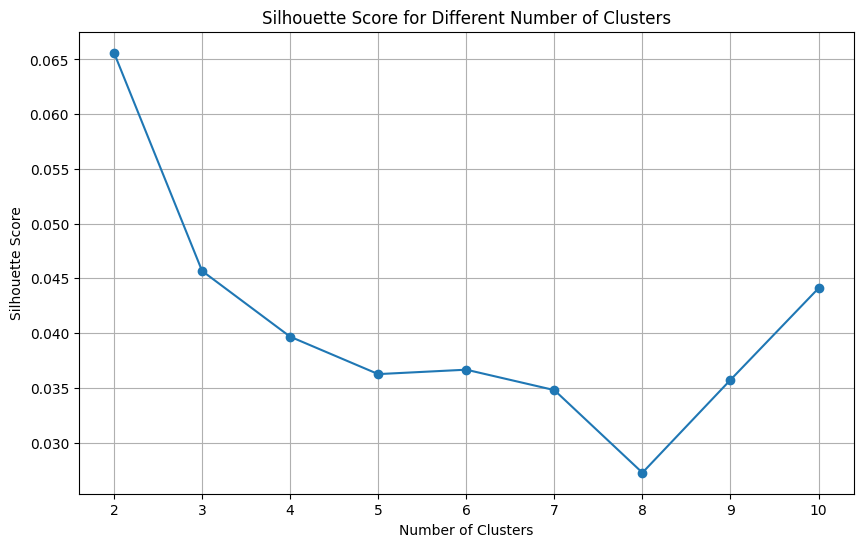

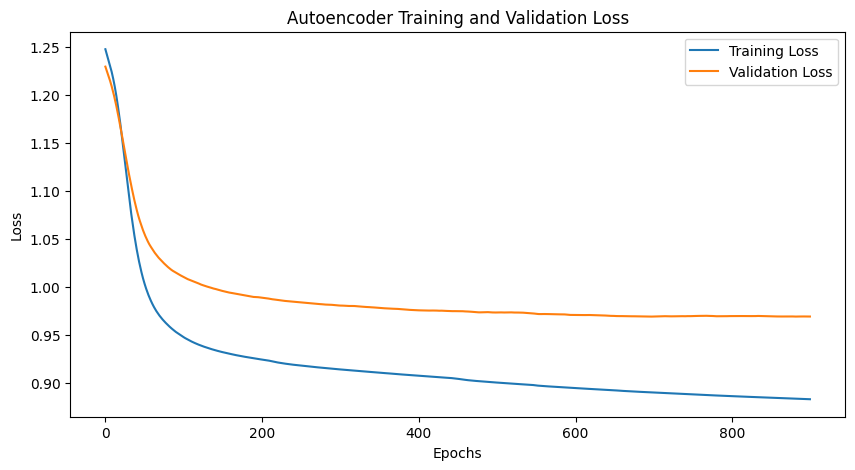

In [12]:
# Function to plot silhouette scores
def plot_silhouette_scores(cluster_range, silhouette_scores, filename=None):
    plt.figure(figsize=(10, 6))
    plt.plot(cluster_range, silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Silhouette Score')
    plt.title('Silhouette Score for Different Number of Clusters')
    plt.grid(True)
    
    if filename:
        plt.savefig(filename)
        print(f'Results saved as {filename}')
    else:
        plt.show()

cluster_range = range(2, 11)  # Küme sayısı aralığı
silhouette_scores = [silhouette for _, _, silhouette in kmeans_results] 
plot_silhouette_scores(cluster_range, silhouette_scores, filename='autoncoder_silhouette_scores.png')

# Function to plot loss during training
def plot_loss(history, title, filename):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig(filename)
    plt.show()


plot_loss(history_02, 'Autoencoder Training and Validation Loss', 'autoencoder_loss_plot.png')


In [13]:

max_silhouette_kmeans = max([silhouette for _, _, silhouette in kmeans_results])
print(f'Max Silhouette Score for K-means: {max_silhouette_kmeans}')

if valid_results:
    max_silhouette_dbscan = max([silhouette for _, _, silhouette in valid_results])
    print(f'Max Silhouette Score for DBSCAN: {max_silhouette_dbscan}')
else:
    print('No valid Silhouette scores found for any combination.')

max_silhouette_autoencoder = float(best_result_deep.split(":")[-1].strip())
print(f'Max Silhouette Score for Autoencoder : {max_silhouette_autoencoder}')

Max Silhouette Score for K-means: 0.06561172867930795
No valid Silhouette scores found for any combination.
Max Silhouette Score for Autoencoder : 0.49337878823280334
